# Mapping mining areas

This notebook shows how to map mining areas using the Segment Anything Model (SAM). 

In [2]:
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
from samgeo.text_sam import LangSAM
import os
import geopandas as gpd

import sys
sys.path.append('..')

from src.data.get_satellite_images import ReadSTAC

import torch
torch.cuda.is_available()

os.getcwd()
root = os.path.dirname(os.getcwd())

# Optional 
root = os.path.join(root, 'mine-segmentation')
root

'/teamspace/studios/this_studio/workspaces/mine-segmentation'

## Load Dataset and Image Loader

In [2]:
# Option 1 (Default): Read from Planetary Computer STAC API
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02']

stac_reader = ReadSTAC(api_url=api_url)

In [3]:
DATASET = root + "/data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"
data = gpd.read_file(DATASET, layer="tiles")
data.head()

,tile_id,s2_tile_id,source_dataset,preferred_dataset,minetype1,minetype2,comment,timestamp,geometry
0,2176,S2B_MSIL2A_20190909T033539_R061_T49VFE_2020100...,both,tang,Surface,Industrial,,2024-06-28 09:11:07.482,"POLYGON ((114.26466 58.16196, 114.25047 58.345..."
1,1866,S2B_MSIL2A_20190121T041059_R047_T46RGN_2020100...,maus,maus,Surface,Industrial,,2024-06-28 09:11:40.081,"POLYGON ((95.68252 24.65585, 95.68649 24.8406,..."
2,653,S2A_MSIL2A_20160305T143722_R096_T20NPL_2021052...,maus,maus,Surface,Industrial,,2024-06-28 09:13:06.719,"POLYGON ((-61.32459 4.65719, -61.32414 4.84238..."
3,2749,S2B_MSIL2A_20200525T022549_R046_T53ULU_2020091...,tang,tang,Surface,Artisanal,,2024-06-28 09:14:55.294,"POLYGON ((132.90662 52.82744, 132.89773 53.011..."
4,152,S2B_MSIL2A_20190919T184039_R070_T12VVJ_2020100...,both,tang,Surface,Industrial,,2024-06-28 09:16:00.696,"POLYGON ((-111.08086 56.99153, -111.08126 57.1..."


In [34]:
row = data.iloc[4,:]

# get the item 
item = stac_reader.get_item_by_name(row.s2_tile_id, bbox=row.geometry.bounds)

# get lat and lon
lat = row.geometry.centroid.y
lon = row.geometry.centroid.x

# read as stack
stack = stac_reader.get_stack(
    items=item, 
    bands=bands,
    crop_to_bounds=False, 
    squeeze_time_dim=True,
    custom_point_and_buffer=[lon, lat, 10240],
    chunk_size=512,
    )

stack_stretched = stac_reader.stretch_contrast_stack(stack)
image = stac_reader.save_stack_as_geotiff(stack_stretched, filename="textprompt_image.tif")

Loading stack...


Returning stack from single S2 image with ID: S2B_MSIL2A_20190919T184039_R070_T12VVJ_20201004T150811
Stretching contrast...
Saving stack as GeoTIFF under: data/interim/textprompt_image.tif


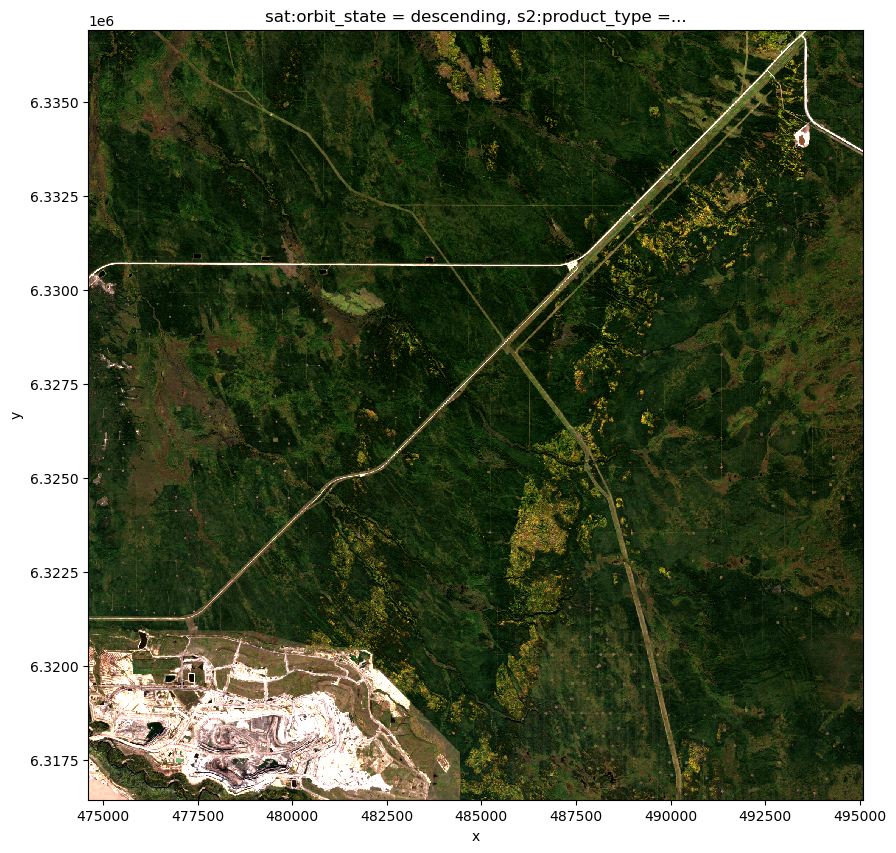

In [35]:
stack_stretched.plot.imshow(robust=True, figsize=(10, 10))

Display the downloaded image on the map.

In [ ]:
m = leafmap.Map()
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [7]:
# https://samgeo.gishub.org/samgeo/#samgeo.samgeo.SamGeo
sam = SamGeo(
    model_type="vit_h", # vit_h (2.4 GB), vit_l (1.2 GB), vit_b (300 MB)
    sam_kwargs=None,
)

Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /teamspace/studios/this_studio/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth


Model checkpoint for vit_h not found.


100%|██████████| 2.56G/2.56G [00:17<00:00, 147MB/s] 


## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [8]:
sam.generate(image, output="data/masks.tif", foreground=True, unique=True)

In [ ]:
sam.show_masks(cmap="binary_r")

## Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [10]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /home/zeus/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:16<00:00, 159MB/s] 


## Specify text prompts

In [28]:
text_prompt = "mine"

## Segment the image

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [36]:
sam.predict(image, text_prompt, box_threshold=0.3, text_threshold=0.3)

## Visualize the results

Show the result with bounding boxes on the map.

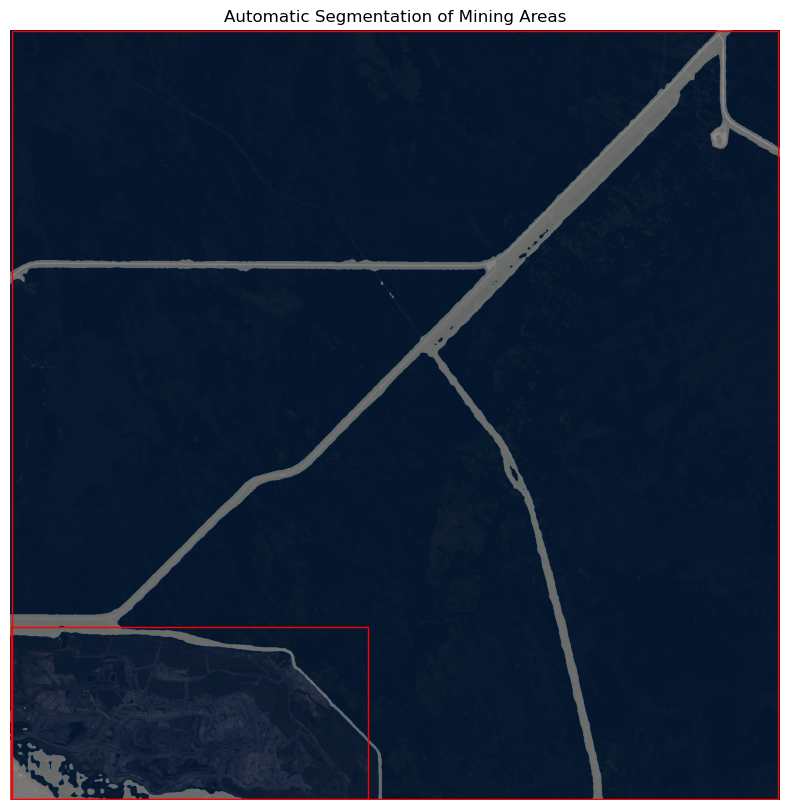

In [37]:
sam.show_anns(
    cmap="Blues",
    box_color="red",
    title="Automatic Segmentation of Mining Areas",
    blend=True,
)

Show the result without bounding boxes on the map.

In [ ]:
sam.show_anns(
    cmap="Blues",
    add_boxes=False,
    alpha=0.5,
    title="Automatic Segmentation of Mining Areas",
)

Show the result as a grayscale image.

In [ ]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Mining areas",
    blend=False,
    output="minearea.tif",
)

Convert the result to a vector format.  

In [18]:
sam.raster_to_vector("minearea.tif", "minearea.shp")

Show the results on the interactive map.

In [ ]:
m.add_raster("minearea.tif", layer_name="minearea", palette="Blues", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("minearea.shp", layer_name="Vector", style=style)
m

## Interactive segmentation

In [77]:
sam.show_map()

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…